## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d

ranger optimser

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from ranger import Ranger

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [ ]:
data_dir = Path('data')

In [5]:
RETRAIN = True
RESIZE_IMAGES = True

In [6]:
MODEL_NAME='cv_reflect_101_ranger'

In [7]:
NB_NUM='03_14'

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: cad86744, DATE: 20191110


In [9]:
#DATE = '20191026'
#UID = '1964891c'

In [10]:
SUB_NUM='17'

In [11]:
img_size=256

In [12]:
train_images=data_dir/f'train/rotated/clipped/reflect/{img_size}'
test_images=data_dir/f'test/rotated/clipped/reflect/{img_size}'

In [13]:
test_names = get_image_files(test_images)

In [14]:
assert len(test_names)==7325

In [15]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [16]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [17]:
df_all=df_all.drop_duplicates(subset=['id'])

In [18]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [19]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [20]:
assert len(df_test)==7325

In [21]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [22]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [23]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [24]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [25]:
#to check what params object has
#dir(data)

In [26]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256

In [27]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

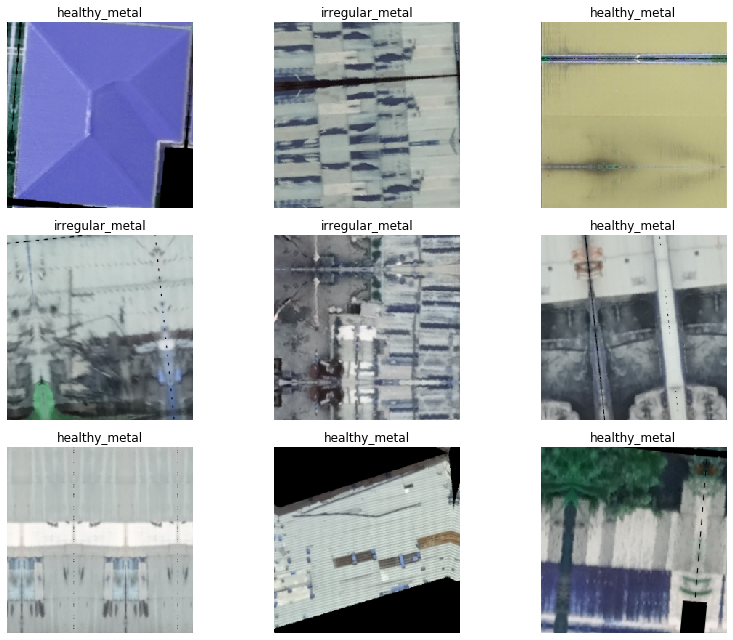

In [28]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [29]:
arch = models.resnet50
arch_name = 'rn50'

In [30]:
optar = partial(Ranger)

In [31]:
learn = cnn_learner(data, arch, opt_func=optar, metrics=error_rate, bn_final=True).to_fp16()

We use the LR Finder to pick a good learning rate.

### (Re)train model

In [32]:
learn.lr_find()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


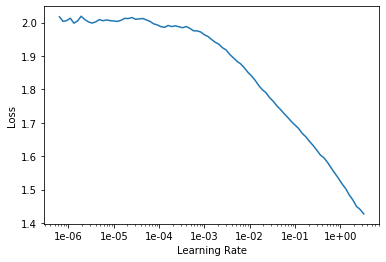

In [33]:
learn.recorder.plot()

Then we can fit the head of our network.

In [34]:
lr = 1e-2

In [35]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.138457,0.940398,0.244789,01:08
1,0.722064,0.662781,0.185588,01:09
2,0.571029,0.530050,0.159645,01:11
3,0.511448,0.496245,0.156541,01:12
4,0.485234,0.498290,0.154989,01:10


<pre>
Adam
 epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.508273 	1.170024 	0.339911 	01:16
1 	0.471699 	0.494651 	0.166297 	01:22
2 	0.439157 	0.417086 	0.152328 	01:23
3 	0.402381 	0.370002 	0.127938 	01:23
4 	0.355355 	0.360440 	0.126608 	01:22
</pre>

In [36]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')


#### Load model

In [37]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.486201,0.489496,0.153215,01:05
1,0.469476,0.452890,0.151441,01:01
2,0.406374,0.412760,0.144124,01:03
3,0.398273,0.404574,0.147007,01:10
4,0.373710,0.402117,0.143902,01:11


In [41]:
learn.save(f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [42]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.365257,0.402352,0.146563,01:10
1,0.388354,0.402843,0.146120,01:05
2,0.370104,0.392086,0.141242,01:04
3,0.360981,0.381108,0.139911,01:01
4,0.348673,0.377871,0.139024,01:01


In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 240),
 ('healthy_metal', 'irregular_metal', 127),
 ('incomplete', 'irregular_metal', 60),
 ('concrete_cement', 'healthy_metal', 40),
 ('other', 'healthy_metal', 36),
 ('incomplete', 'healthy_metal', 23),
 ('concrete_cement', 'irregular_metal', 19),
 ('healthy_metal', 'concrete_cement', 18),
 ('concrete_cement', 'incomplete', 14),
 ('irregular_metal', 'concrete_cement', 11),
 ('incomplete', 'concrete_cement', 10),
 ('irregular_metal', 'incomplete', 10),
 ('other', 'irregular_metal', 7),
 ('irregular_metal', 'other', 5),
 ('healthy_metal', 'incomplete', 3),
 ('healthy_metal', 'other', 2)]

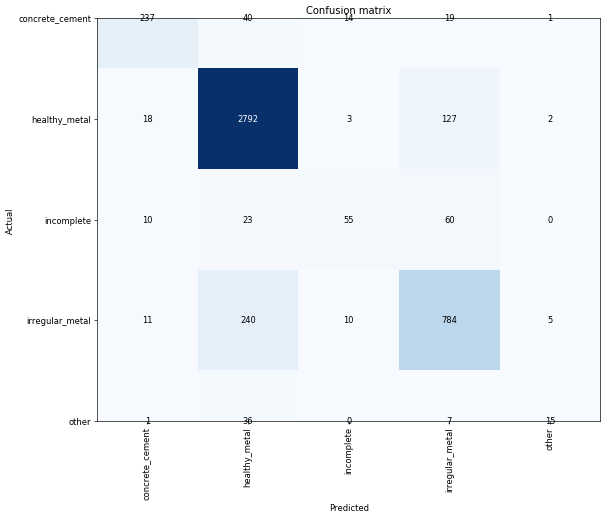

In [44]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [45]:
learn.unfreeze()

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


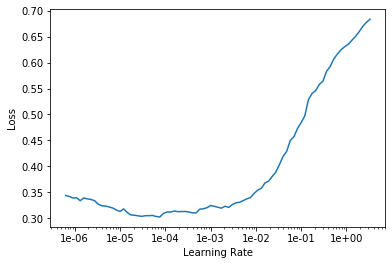

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.336308,0.381034,0.138803,01:17
1,0.343607,0.373911,0.132372,01:18
2,0.326948,0.374116,0.130599,01:18
3,0.289326,0.366132,0.128603,01:17
4,0.268331,0.368629,0.135477,01:19


<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.438103 	0.431031 	0.157428 	01:37
1 	0.413694 	0.500094 	0.179823 	01:38
2 	0.405334 	0.394548 	0.143902 	01:35
3 	0.400567 	0.368481 	0.135920 	01:35
4 	0.352880 	0.357799 	0.128381 	01:35
    </pre>

In [48]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [49]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [50]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.254495,0.372939,0.132594,01:17
1,0.287845,0.395184,0.139468,01:17
2,0.261973,0.380542,0.131486,01:18
3,0.224126,0.383904,0.135477,01:17
4,0.189800,0.388132,0.135698,01:18


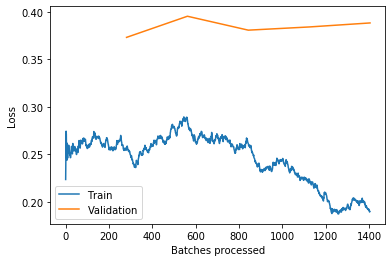

In [51]:
learn.recorder.plot_losses()

In [53]:
learn.save(f'stage-2-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [54]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/reflect/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/reflect/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=

In [56]:
learn=learn.to_fp32()

In [57]:
learn.export()

### inference

In [58]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [59]:
len(test_dataset)

7325

In [60]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/reflect/{img_size}', test=test_dataset)

In [61]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [62]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [63]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [64]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [65]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [66]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [67]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [68]:
labels = np.argmax(preds, 1)

In [69]:
len(preds)

7325

In [70]:
preds[0].tolist()

[0.013550885021686554,
 0.9738914370536804,
 0.0022063220385462046,
 0.0073822722770273685,
 0.0029692337848246098]

In [71]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [72]:
len(labels)

7325

In [73]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [74]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [75]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [76]:
test_predictions[0]

'healthy_metal'

In [77]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [78]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/reflect/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/reflect/256/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/reflect/256/7a4d27b4.tif')], dtype=object)

In [79]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [80]:
preds_list[0]

[0.013550885021686554,
 0.9738914370536804,
 0.0022063220385462046,
 0.0073822722770273685,
 0.0029692337848246098]

In [81]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [82]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [83]:
df.head()

,id,pred
0,7a4d9168,"[0.013550885021686554, 0.9738914370536804, 0.0..."
1,7a4ae922,"[0.00651128962635994, 0.9298616051673889, 0.00..."
2,7a48ca98,"[0.016317790374159813, 0.15616460144519806, 0...."
3,7a49c614,"[0.003456693608313799, 0.9416074752807617, 0.0..."
4,7a4dd4f2,"[0.006835892330855131, 0.700330913066864, 0.00..."


In [84]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [85]:
pred_df.insert(loc=0, column='id', value=ids)

In [86]:
pred_df.columns = cols

In [87]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.013551,0.973891,0.002206,0.007382,0.002969
1,7a4ae922,0.006511,0.929862,0.001232,0.059889,0.002506
2,7a48ca98,0.016318,0.156165,0.029898,0.792112,0.005508
3,7a49c614,0.003457,0.941607,0.002747,0.048027,0.004161
4,7a4dd4f2,0.006836,0.700331,0.007340,0.263445,0.022048


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [88]:
pred_ids=pred_df['id'].values.tolist()

In [89]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [90]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [91]:
baseline_ids=df_baseline['id'].values.tolist()

In [92]:
baseline_ids

['7a4d630a',
 '7a4bbbd6',
 '7a4ac744',
 '7a4881fa',
 '7a4aa4a8',
 '7a514434',
 '7a485f72',
 '7a4b8d32',
 '7a47eb3c',
 '7a4be3ae',
 '7a46a330',
 '7a481620',
 '7a49c678',
 '7a4ea044',
 '7a47aa1e',
 '7a51aa1e',
 '7a498be0',
 '7a4a2848',
 '7a4c4cd6',
 '7a465038',
 '7a4e94aa',
 '7a49f62a',
 '7a45b6f0',
 '7a50bb90',
 '7a4d38e4',
 '7a48a3a6',
 '7a4ebe9e',
 '7a48352e',
 '7a4bfaec',
 '7a51e060',
 '7a4c0f5a',
 '7a4b9976',
 '7a4b27d4',
 '7a51c698',
 '7a474bb4',
 '7a480054',
 '7a4a4044',
 '7a4c35ca',
 '7a4d3fd8',
 '7a4c1a68',
 '7a4eb1c4',
 '7a4a51ce',
 '7a4a14fc',
 '7a5015d2',
 '7a4ba95c',
 '7a5101ae',
 '7a4d0a22',
 '7a5134ee',
 '7a4a85c2',
 '7a514b14',
 '7a4d0a90',
 '7a485fd6',
 '7a4f668c',
 '7a44e752',
 '7a5162d4',
 '7a465894',
 '7a4c9a10',
 '7a485810',
 '7a4a9788',
 '7a503198',
 '7a4e206a',
 '7a4c15ea',
 '7a4f8536',
 '7a513df4',
 '7a4d7624',
 '7a4c9e8e',
 '7a4b2554',
 '7a502b12',
 '7a4c32e6',
 '7a4a8a2c',
 '7a467b76',
 '7a51b554',
 '7a4622e8',
 '7a4a599e',
 '7a4d17c4',
 '7a4fb740',
 '7a4ceed4',

In [93]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [94]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [95]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.013551,0.973891,0.002206,0.007382,0.002969,7a4d9168
1,7a4ae922,0.006511,0.929862,0.001232,0.059889,0.002506,7a4ae922
2,7a48ca98,0.016318,0.156165,0.029898,0.792112,0.005508,7a48ca98
3,7a49c614,0.003457,0.941607,0.002747,0.048027,0.004161,7a49c614
4,7a4dd4f2,0.006836,0.700331,0.007340,0.263445,0.022048,7a4dd4f2


In [96]:
pred_df=pred_df.sort_values('id_cat')

In [97]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.006790,0.948398,0.004442,0.034373,0.005997,7a4d630a
764,7a4bbbd6,0.002873,0.954727,0.002124,0.038080,0.002195,7a4bbbd6
1841,7a4ac744,0.008112,0.785970,0.005774,0.196487,0.003656,7a4ac744
3363,7a4881fa,0.001710,0.011528,0.027815,0.957231,0.001716,7a4881fa
133,7a4aa4a8,0.010537,0.949475,0.001940,0.036658,0.001390,7a4aa4a8


In [98]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [99]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [100]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

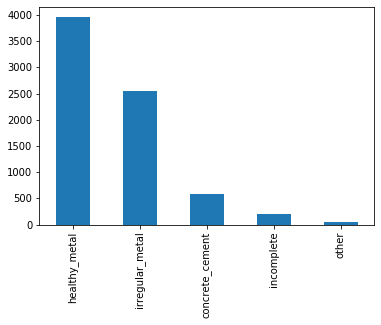

In [101]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")